# Prédiction du montant de pourboires payé pour des courses de taxi à New-York

In [194]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_regression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
# Importation des jeux de données (à personnaliser)
data_train = pd.read_parquet("path_to_train.parquet")
data_test = pd.read_parquet("path_to_test.parquet")

In [258]:
# Importation des jeux de données
data_train = pd.read_parquet(r"C:\Users\alici\Documents\Cours\Universite\MIA\M2\SP\Challenges\Taxis_tips\nyc-taxis-tips\train.parquet")
data_test = pd.read_parquet(r"C:\Users\alici\Documents\Cours\Universite\MIA\M2\SP\Challenges\Taxis_tips\nyc-taxis-tips\test.parquet")

# I. Analyse des données

## A. Première approche

In [259]:
data_train.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon
0,1,2024-01-15 20:37:28,2024-01-15 20:56:43,1.0,3.30,1.0,N,1,19.1,3.5,0.5,4.80,0.0,1.0,2.5,0.0,40.734576,-74.002875,40.768615,-73.965635
1,2,2024-01-25 19:41:24,2024-01-25 19:44:42,1.0,0.72,1.0,N,1,5.8,2.5,0.5,2.46,0.0,1.0,2.5,0.0,40.768615,-73.965635,40.780436,-73.957012
2,2,2024-01-25 15:48:48,2024-01-25 16:24:23,2.0,7.45,1.0,N,1,38.7,0.0,0.5,3.00,0.0,1.0,2.5,0.0,40.717773,-74.007880,40.780436,-73.957012
3,2,2024-01-27 00:47:26,2024-01-27 00:55:55,1.0,1.53,1.0,N,1,10.0,1.0,0.5,2.25,0.0,1.0,2.5,0.0,40.720889,-73.996919,40.747746,-73.978492
4,2,2024-01-28 13:14:26,2024-01-28 13:22:34,1.0,1.53,1.0,N,1,10.0,0.0,0.5,3.50,0.0,1.0,2.5,0.0,40.768615,-73.965635,40.747746,-73.978492


Dans ce jeu de données, nous cherchons à prédire la variable tip_amount.

In [260]:
data_train.dtypes

VendorID                          int32
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
congestion_surcharge            float64
Airport_fee                     float64
PU_location_lat                 float64
PU_location_lon                 float64
DO_location_lat                 float64
DO_location_lon                 float64
dtype: object

In [261]:
data_train.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon
count,100000.000000,100000,100000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.759540,2024-01-17 01:37:59.341699840,2024-01-17 01:53:39.024740096,1.335090,3.213008,1.998210,1.186610,18.044264,1.538507,0.497315,3.430985,0.525877,0.999882,2.335125,0.140857,40.752187,-73.965628,40.754760,-73.971940
min,1.000000,2023-12-31 23:56:46,2024-01-01 00:03:50,0.000000,0.010000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.576961,-74.174002,40.528686,-74.187679
25%,2.000000,2024-01-09 15:34:38,2024-01-09 15:50:20.750000128,1.000000,1.000000,1.000000,1.000000,8.600000,0.000000,0.500000,1.000000,0.000000,1.000000,2.500000,0.000000,40.740439,-73.989845,40.740337,-73.989845
50%,2.000000,2024-01-17 11:32:54.500000,2024-01-17 11:51:50,1.000000,1.690000,1.000000,1.000000,12.800000,1.000000,0.500000,2.800000,0.000000,1.000000,2.500000,0.000000,40.758028,-73.977698,40.758028,-73.977698
75%,2.000000,2024-01-24 18:09:36,2024-01-24 18:28:48.500000,1.000000,3.100000,1.000000,1.000000,19.800000,2.500000,0.500000,4.200000,0.000000,1.000000,2.500000,0.000000,40.773633,-73.965146,40.773633,-73.961764
max,2.000000,2024-01-31 23:59:07,2024-02-01 10:57:24,7.000000,53.640000,99.000000,4.000000,214.800000,11.750000,0.500000,99.000000,49.260000,1.000000,2.500000,1.750000,40.899528,-73.726655,40.899528,-73.711025
std,0.427365,NaN,NaN,0.847745,4.219928,9.594546,0.458398,15.839824,1.788004,0.036542,3.686474,2.020583,0.009412,0.620490,0.476090,0.032148,0.048564,0.031182,0.036295


In [262]:
data_test.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon
count,2.627163e+06,2627163,2627163,2.627163e+06,2.627163e+06,2.627163e+06,2.627163e+06,2.627163e+06,2.627163e+06,2.627163e+06,2.627163e+06,2.627163e+06,2.627163e+06,2.627163e+06,2.627163e+06,2.627163e+06,2.627163e+06,2.627163e+06
mean,1.759324e+00,2024-01-17 01:43:13.110948864,2024-01-17 01:58:52.406438656,1.339094e+00,3.224451e+00,2.021085e+00,1.185402e+00,1.808981e+01,1.550850e+00,4.974680e-01,5.239940e-01,9.999077e-01,2.333000e+00,1.425405e-01,4.075211e+01,-7.396549e+01,4.075476e+01,-7.397195e+01
min,1.000000e+00,2002-12-31 22:59:39,2002-12-31 23:05:41,0.000000e+00,1.000000e-02,1.000000e+00,1.000000e+00,0.000000e+00,-2.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.055913e+01,-7.417400e+01,4.052549e+01,-7.423354e+01
25%,2.000000e+00,2024-01-09 15:58:07,2024-01-09 16:15:23.500000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,8.600000e+00,0.000000e+00,5.000000e-01,0.000000e+00,1.000000e+00,2.500000e+00,0.000000e+00,4.074044e+01,-7.398984e+01,4.074034e+01,-7.398984e+01
50%,2.000000e+00,2024-01-17 10:57:04,2024-01-17 11:15:51,1.000000e+00,1.690000e+00,1.000000e+00,1.000000e+00,1.280000e+01,1.000000e+00,5.000000e-01,0.000000e+00,1.000000e+00,2.500000e+00,0.000000e+00,4.075803e+01,-7.397770e+01,4.075803e+01,-7.397770e+01
75%,2.000000e+00,2024-01-24 18:54:06,2024-01-24 19:08:48,1.000000e+00,3.100000e+00,1.000000e+00,1.000000e+00,1.980000e+01,2.500000e+00,5.000000e-01,0.000000e+00,1.000000e+00,2.500000e+00,0.000000e+00,4.077363e+01,-7.396515e+01,4.077363e+01,-7.396176e+01
max,2.000000e+00,2024-02-01 00:01:15,2024-02-01 22:04:34,9.000000e+00,8.000000e+01,9.900000e+01,4.000000e+00,8.200000e+02,1.425000e+01,4.000000e+00,9.546000e+01,1.000000e+00,2.500000e+00,1.750000e+00,4.089953e+01,-7.371103e+01,4.089953e+01,-7.371103e+01
std,4.274942e-01,NaN,NaN,8.508770e-01,4.231871e+00,9.710419e+00,4.562516e-01,1.594478e+01,1.799518e+00,3.578980e-02,2.017657e+00,8.301661e-03,6.241870e-01,4.786734e-01,3.210918e-02,4.874899e-02,3.124374e-02,3.619966e-02


## B. Données anormales

### Date

In [263]:
# Dataset train
annees_distinctes = data_train['tpep_pickup_datetime'].dt.year.unique()
print("Années distinctes :", annees_distinctes)

mois_distincts = data_train['tpep_pickup_datetime'].dt.month.unique()
print("Mois distincts :", mois_distincts)

counts_par_annee = data_train['tpep_pickup_datetime'].dt.year.value_counts().sort_index()
print(counts_par_annee)

Années distinctes : [2024 2023]
Mois distincts : [ 1 12]
tpep_pickup_datetime
2023        1
2024    99999
Name: count, dtype: int64


Nous observons 1 valeur en décembre 2023 et  99 999 en janvier 2024 dans notre jeu de données d'entraînement.

In [264]:
# Dataset test
annees_distinctes = data_test['tpep_pickup_datetime'].dt.year.unique()
print("Années distinctes :", annees_distinctes)

mois_distincts = data_test['tpep_pickup_datetime'].dt.month.unique()
print("Mois distincts :", mois_distincts)

counts_par_annee = data_test['tpep_pickup_datetime'].dt.year.value_counts().sort_index()
print(counts_par_annee)

Années distinctes : [2024 2023 2002]
Mois distincts : [ 1  2 12]
tpep_pickup_datetime
2002          1
2023          9
2024    2627153
Name: count, dtype: int64


Nous observons 1 valeur en 2002, 9 valeurs en 2023 et 2 627 153 en 2024 dans notre jeu de données de test. De plus, nous avons des valeurs en décembre, janvier, février alors que nous devions avoir que des dates au mois de janvier. Et, nous ne pouvons pas enlever les lignes erronées car elles doivent toutes être prédites pour ne pas modifier le nombre de ligne.

Comme la valeur en 2002 est en décembre, nous allons changer l'année en 2023 car nous supposons une erreur. Car toutes le autres courses du 31 décembre sont en 2023. Et pour le reste nous n'allons rien changer.

In [265]:
# Remplacer l'année 2002 par 2023 dans la colonne 'tpep_pickup_datetime'
data_test['tpep_pickup_datetime'] = data_test['tpep_pickup_datetime'].apply(lambda x: x.replace(year=2023) 
                                                                            if x.year == 2002 else x)
data_test['tpep_dropoff_datetime'] = data_test['tpep_dropoff_datetime'].apply(lambda x: x.replace(year=2023) 
                                                                              if x.year == 2002 else x)

### Trajets annulés

In [266]:
trajets_annules_train = data_train[data_train['tpep_pickup_datetime'] == data_train['tpep_dropoff_datetime']]

print("Lignes avec trajets annulés (même heure de prise en charge et de dépôt) :")
print(trajets_annules_train[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'tip_amount']]) # vérifier le montant du pourboire

Lignes avec trajets annulés (même heure de prise en charge et de dépôt) :
      tpep_pickup_datetime tpep_dropoff_datetime  tip_amount
75212  2024-01-20 16:00:43   2024-01-20 16:00:43         0.0


Dans le jeu train, il y a un trajet dont les horaires de départ et d'arrivée sont identiques, on suppose qu'il s'agit d'un trajet annulé. De plus, nous observons un montant de pourboire à 0, ce qui correspondrait bien. Nous allons donc faire cette hypothèse dans la suite : lorsque les horaires de départ et d'arrivée sont identiques, le pourboire est à 0.

In [267]:
trajets_annules_test = data_test[data_test['tpep_pickup_datetime'] == data_test['tpep_dropoff_datetime']]

print(f"Nombre de trajets annulés : {trajets_annules_test.shape[0]}")

Nombre de trajets annulés : 33


Dans notre jeu test, il y a 33 trajets annulés, donc 33 lignes dont nous fixerons la prédiction à 0.

### Type de tarif

In [268]:
# Dataset train
tarifs_distincts_train = data_train['RatecodeID'].unique()
print(f"Tarifs distincts : {tarifs_distincts_train}")

Tarifs distincts : [ 1.  2.  3.  5. 99.  4.]


In [269]:
tarif_errone_train = data_train[data_train['RatecodeID'] == 99.]
print(f"Nombre de tarifs à 99 : {tarif_errone_train.shape[0]}")

Nombre de tarifs à 99 : 968


La variable tarif est une variable qualitative qui contient 6 classes (de 1 à 6). Dans notre jeu d'entraînement, nous constatons qu'il n'y a pas de classe 6, mais l'apparition d'une classe 99.

Nous supposons donc une erreur. Nous allons changer la classe 99 en classe 6.

In [270]:
# Dataset train
tarifs_distincts_test = data_test['RatecodeID'].unique()
print(f"Tarifs distincts : {tarifs_distincts_test}")

tarif_errone_test = data_train[data_train['RatecodeID'] == 99.]
print(f"Nombre de tarifs à 99 : {tarif_errone_test.shape[0]}")

Tarifs distincts : [ 1.  2.  3. 99.  5.  4.  6.]
Nombre de tarifs à 99 : 968


De même nous observons plusieurs tarifs à 99 mais cette fois nous avons la classe 6. Nous gardons quand même notre hypothèse ci-dessus. Nous allons changer la classe 99 en classe 6 aussi dans ce jeu de données.

In [271]:
# Remplace la classe 99 par 6 dans la colonne RatecodeID
data_train['RatecodeID'] = data_train['RatecodeID'].replace(99, 6)
data_test['RatecodeID'] = data_test['RatecodeID'].replace(99, 6)

## C. Analyse des données

In [272]:
# Variables qualitative à transformer en classe
quali = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'payment_type', 'improvement_surcharge', 'Airport_fee']

for colonne in quali:
    if colonne == 'store_and_fwd_flag':
        data_train[colonne] = data_train[colonne].astype('category')
        data_test[colonne] = data_test[colonne].astype('category')
    else :
        data_train[colonne] = data_train[colonne].astype(int).astype('category')
        data_test[colonne] = data_test[colonne].astype(int).astype('category')

In [273]:
data_train.dtypes

VendorID                       category
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                     category
store_and_fwd_flag             category
payment_type                   category
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge          category
congestion_surcharge            float64
Airport_fee                    category
PU_location_lat                 float64
PU_location_lon                 float64
DO_location_lat                 float64
DO_location_lon                 float64
dtype: object

### Corrélation linéaire entre les variables quantitatives

In [274]:
data_quanti = data_train.drop(columns=quali)
data_quanti = data_quanti.drop(columns=['tpep_pickup_datetime','tpep_dropoff_datetime'])
corr = data_quanti.corr()
corr.style.background_gradient(cmap='viridis')

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,congestion_surcharge,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon
passenger_count,1.000000,0.038208,0.042329,-0.052623,-0.020669,0.017716,0.031222,0.015110,-0.028713,0.010192,-0.019462,-0.003999
trip_distance,0.038208,1.000000,0.953290,0.180328,-0.142445,0.600140,0.672078,-0.339625,-0.500258,0.684447,-0.240775,0.258394
fare_amount,0.042329,0.953290,1.000000,0.165893,-0.246245,0.623595,0.664040,-0.333379,-0.470078,0.634433,-0.255381,0.234321
extra,-0.052623,0.180328,0.165893,1.000000,0.025574,0.211149,0.260188,-0.026850,0.041652,0.173236,0.002136,0.073292
mta_tax,-0.020669,-0.142445,-0.246245,0.025574,1.000000,-0.152406,-0.308053,0.203202,0.032358,-0.034705,0.098271,0.144290
tip_amount,0.017716,0.600140,0.623595,0.211149,-0.152406,1.000000,0.500822,-0.084581,-0.247990,0.383503,-0.128718,0.069843
tolls_amount,0.031222,0.672078,0.664040,0.260188,-0.308053,0.500822,1.000000,-0.153643,-0.210098,0.439725,-0.084522,0.076505
congestion_surcharge,0.015110,-0.339625,-0.333379,-0.026850,0.203202,-0.084581,-0.153643,1.000000,0.251174,-0.504517,0.147563,-0.346139
PU_location_lat,-0.028713,-0.500258,-0.470078,0.041652,0.032358,-0.247990,-0.210098,0.251174,1.000000,-0.456329,0.386668,-0.079164
PU_location_lon,0.010192,0.684447,0.634433,0.173236,-0.034705,0.383503,0.439725,-0.504517,-0.456329,1.000000,-0.086866,0.312641


Nous observons une corrélation (> 0.5) entre plusieurs variables et notre variable cible (tip_amount) : 
- trip_distance (distance totale du trajet)
- fare_amount (tarif de la course sur la base de la distance et du temps)
- tolls_amount (montant des péages payés durant le trajet)

Nous observons quelques importances légères avec notre variable cible:
- PU_location_lat (latitude du départ de la course)
- PU_location_lon (longitude du départ de la course)

Nous observons donc quelques linéairité dans notre jeu de données.

### Analyse de la répartition des points

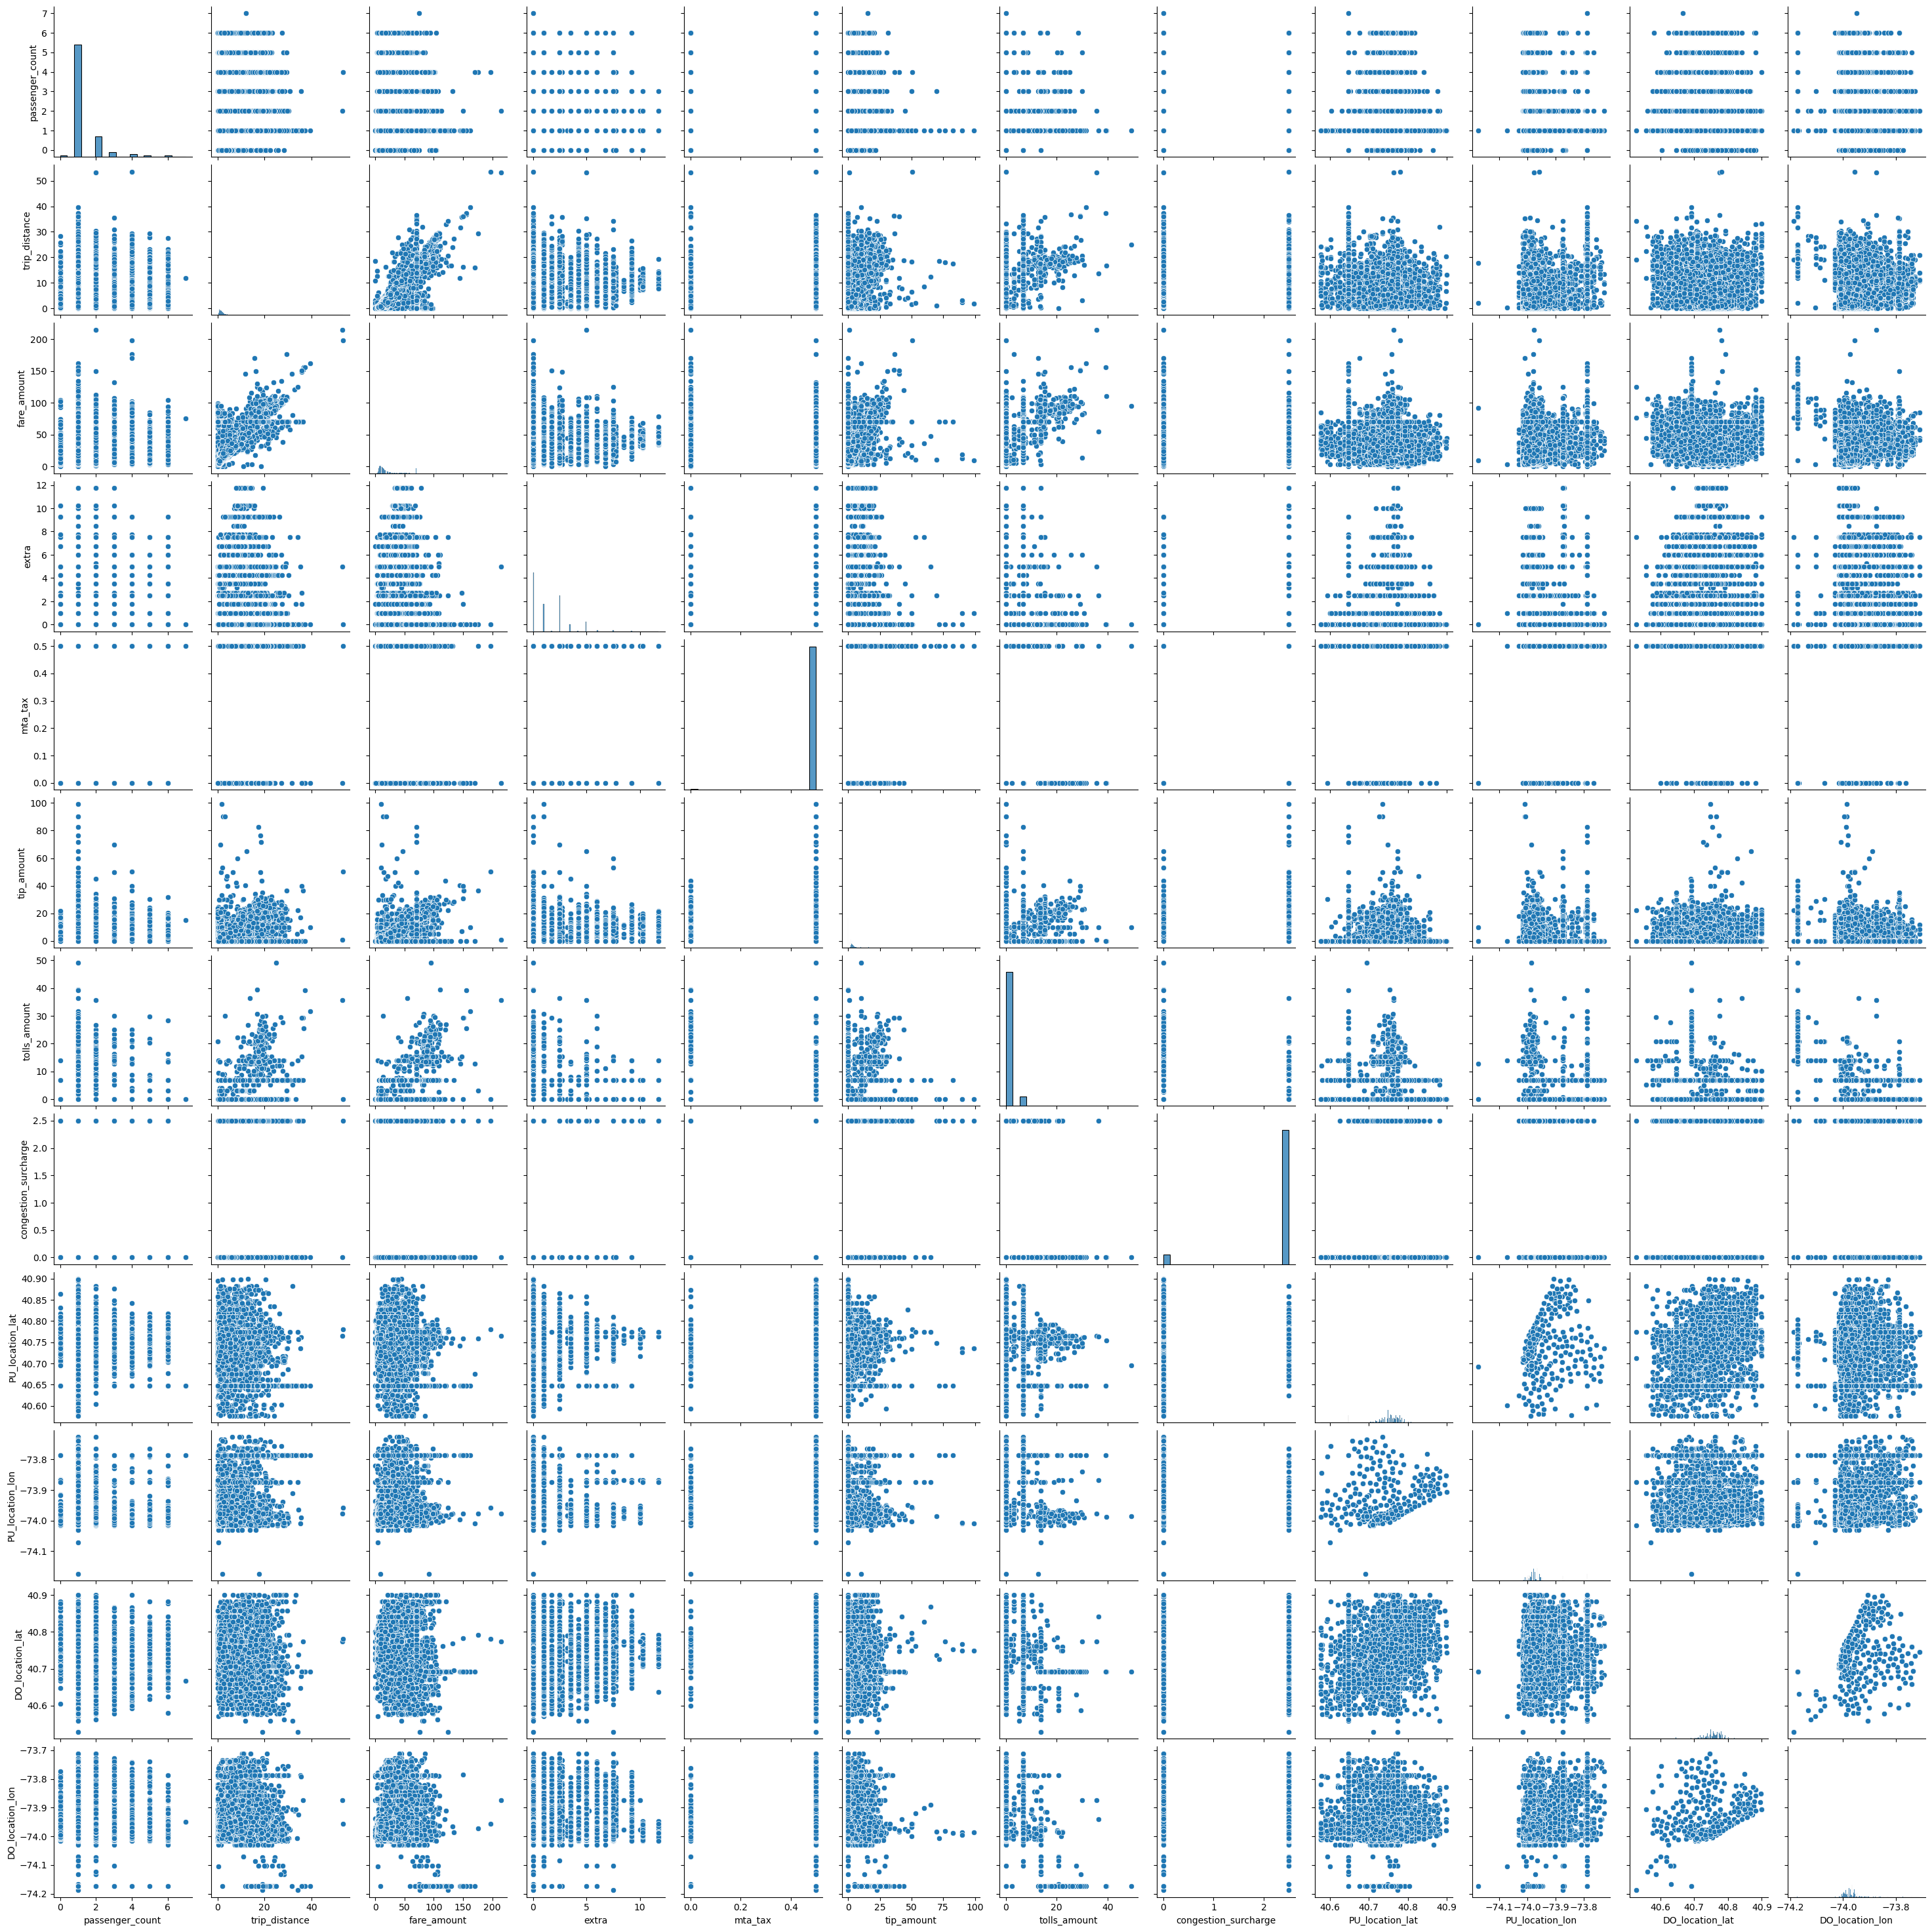

In [275]:
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.pairplot(data_quanti)
plt.show()

Nous observons une répartition linéaire pour les mêmes variables dont nous trouvions une corrélation linéaire.

# II. Preprocessing des données

## A. Ajout de variables

### Durée

In [276]:
# Nous prenons des informations de la variable datetime
data_train['duree'] = data_train['tpep_dropoff_datetime'] - data_train['tpep_pickup_datetime']
data_train['duree'] = data_train['duree'].dt.total_seconds() /3600

data_test['duree'] = data_test['tpep_dropoff_datetime'] - data_test['tpep_pickup_datetime']
data_test['duree'] = data_test['duree'].dt.total_seconds() /3600

### Jour

In [277]:
def determine_jour(date):
    """
    Détermine le jour de la semaine pour une date donnée.

    Parameters:
    ----------
    date : datetime.date
        La date pour laquelle le jour de la semaine doit être déterminé.

    Returns:
    -------
    jour : int
        Un entier représentant le jour de la semaine :
        - 0 pour Lundi
        - 1 pour Mardi
        - 2 pour Mercredi
        - 3 pour Jeudi
        - 4 pour Vendredi
        - 5 pour Samedi
        - 6 pour Dimanche
    """
    jour = date.weekday()
    return jour

data_train_jour = data_train.copy()

data_train_jour['Jour'] = data_train_jour['tpep_pickup_datetime'].apply(determine_jour).astype('category')

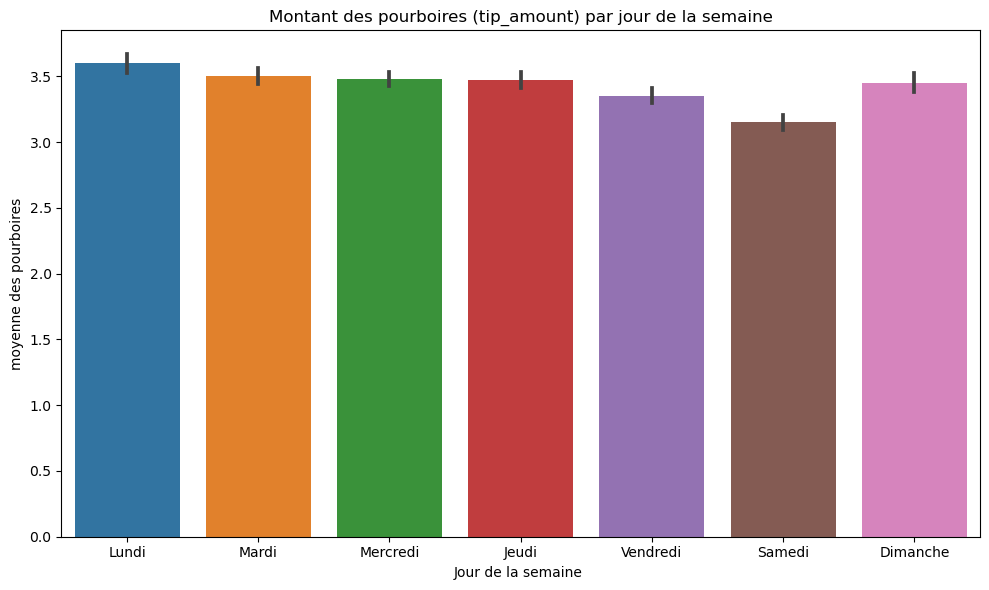

In [278]:
plt.figure(figsize=(10, 6))
sns.barplot(data=data_train_jour, x='Jour', y='tip_amount', estimator='mean') 
plt.title('Montant des pourboires (tip_amount) par jour de la semaine')
plt.xlabel('Jour de la semaine ')
plt.ylabel('moyenne des pourboires')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche'])
plt.tight_layout()
plt.show()

Il n'y a pas de grosse différence entre les jours. Nous avons testé une prédiction avec cette variable et sans, cela n'apportait pas beaucoup d'information. Nous avons donc décidé de ne pas ajouter cette variable.

### Période

In [279]:
def determine_heure(date):
    """
    Détermine la période de la journée à laquelle appartient une heure donnée.

    Parameters:
    ----------
    date : datetime.datetime
        Une instance de la classe `datetime.datetime` représentant la date et l'heure 
        pour laquelle la période de la journée doit être déterminée.

    Returns:
    -------
    periode : str
        Une chaîne de caractères décrivant la période de la journée :
        - 'matin' : de 5h00 à 10h59.
        - 'midi' : de 11h00 à 12h59.
        - 'apres-midi' : de 13h00 à 15h59.
        - 'rush' : de 16h00 à 17h59.
        - 'soiree' : de 18h00 à 21h59.
        - 'nuit' : de 22h00 à 4h59.
    """
    hour = date.hour
    if 5 <= hour < 11:
        return 'matin'
    if 11 <= hour < 13:
        return 'midi'
    elif 13<= hour < 16:
        return 'apres-midi'
    elif 16 <= hour < 18:
        return 'rush'
    elif 18 <= hour < 22:
        return 'soiree'
    else:
        return 'nuit'

data_train['periode'] = data_train['tpep_pickup_datetime'].apply(determine_heure).astype('category')
data_test['periode'] = data_test['tpep_pickup_datetime'].apply(determine_heure).astype('category')

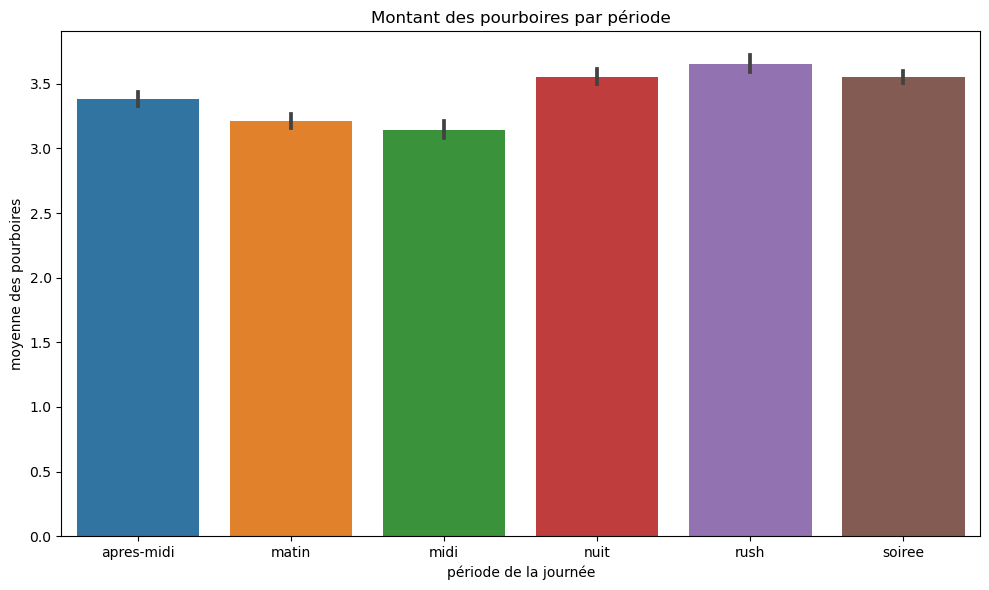

In [280]:
plt.figure(figsize=(10, 6))
sns.barplot(data=data_train, x='periode', y='tip_amount', estimator='mean') #tip amount en fonction de periode

plt.title('Montant des pourboires par période')
plt.xlabel('période de la journée')
plt.ylabel('moyenne des pourboires')
plt.tight_layout()
plt.show()

In [290]:
# Enlève les colonnes inutiles, dont l'information a été récupéré
df_train = data_train.drop(columns=['tpep_dropoff_datetime', 'tpep_pickup_datetime'])
df_test = data_test.drop(columns=['tpep_dropoff_datetime', 'tpep_pickup_datetime'])

### Météo

In [291]:
weather_df = pd.read_excel(r"C:\Users\alici\Documents\Cours\Universite\MIA\M2\SP\Challenges\Taxis_tips\nyc-taxis-tips\export.xlsx")
# Afficher les premières lignes pour vérifier que le fichier est bien chargé
print(weather_df.head())
weather_df.dtypes

         date  tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt    pres  tsun
0  2023-12-31   5.5   4.4   6.1   0.0   NaN   275   9.1   NaN  1014.8   NaN
1  2024-01-01   6.0   3.3   9.4   0.0   NaN   325   7.1   NaN  1017.1   NaN
2  2024-01-02   3.4   0.0   7.8   0.0   NaN   306   8.7   NaN  1018.4   NaN
3  2024-01-03   4.0   1.7   7.2   0.0   NaN   256  10.6   NaN  1016.8   NaN
4  2024-01-04   4.2  -1.1   8.9   0.0   NaN   289   7.7   NaN  1016.7   NaN


date     object
tavg    float64
tmin    float64
tmax    float64
prcp    float64
snow    float64
wdir      int64
wspd    float64
wpgt    float64
pres    float64
tsun    float64
dtype: object

In [292]:
# Suppression des colonnes inutiles
colonnes_a_supprimer = ['snow', 'tsun', 'wdir', 'wpgt']  
weather_df = weather_df.drop(columns=colonnes_a_supprimer)

print(weather_df.head())

         date  tavg  tmin  tmax  prcp  wspd    pres
0  2023-12-31   5.5   4.4   6.1   0.0   9.1  1014.8
1  2024-01-01   6.0   3.3   9.4   0.0   7.1  1017.1
2  2024-01-02   3.4   0.0   7.8   0.0   8.7  1018.4
3  2024-01-03   4.0   1.7   7.2   0.0  10.6  1016.8
4  2024-01-04   4.2  -1.1   8.9   0.0   7.7  1016.7


In [293]:
# Extraire la date au format 'YYYY-MM-DD' à partir de 'tpep_pickup_datetime' et la convertir en chaîne de caractères
df_train['date'] = data_train['tpep_pickup_datetime'].dt.strftime('%Y-%m-%d')
df_test['date'] = data_test['tpep_pickup_datetime'].dt.strftime('%Y-%m-%d')

# Ajout des variables météo
df_train = df_train.merge(weather_df, on='date', how='left')
df_test = df_test.merge(weather_df, on='date', how='left')

# Enlève la colonne créer
df_train = df_train.drop(columns='date')
df_test = df_test.drop(columns='date')

In [294]:
df_train

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,...,tmax_y,prcp_y,wspd_y,pres_y,tavg,tmin,tmax,prcp,wspd,pres
0,1,1.0,3.30,1,N,1,19.1,3.5,0.5,4.80,...,-1.7,0.5,13.9,1024.0,-2.6,-3.9,-1.7,0.5,13.9,1024.0
1,2,1.0,0.72,1,N,1,5.8,2.5,0.5,2.46,...,12.2,6.1,9.4,1021.2,9.7,7.0,12.2,6.1,9.4,1021.2
2,2,2.0,7.45,1,N,1,38.7,0.0,0.5,3.00,...,12.2,6.1,9.4,1021.2,9.7,7.0,12.2,6.1,9.4,1021.2
3,2,1.0,1.53,1,N,1,10.0,1.0,0.5,2.25,...,7.8,0.0,5.6,1022.4,6.7,5.6,7.8,0.0,5.6,1022.4
4,2,1.0,1.53,1,N,1,10.0,0.0,0.5,3.50,...,6.0,19.4,17.2,1010.2,4.1,3.3,6.0,19.4,17.2,1010.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2,1.0,4.38,1,N,1,26.1,0.0,0.5,3.00,...,0.6,2.1,10.6,1011.2,-0.6,-2.8,0.6,2.1,10.6,1011.2
99996,2,1.0,5.34,1,N,1,25.4,1.0,0.5,6.08,...,12.2,6.1,9.4,1021.2,9.7,7.0,12.2,6.1,9.4,1021.2
99997,1,1.0,10.10,6,N,1,35.5,0.0,0.5,0.00,...,8.9,0.0,6.5,1026.8,4.9,2.8,8.9,0.0,6.5,1026.8
99998,2,1.0,5.82,1,N,2,36.6,0.0,0.5,0.00,...,3.3,14.5,18.0,1017.6,1.8,0.0,3.3,14.5,18.0,1017.6


### Aéroport

Les aéroports semblent être des clusters qui regroupent de nombreux trajets avec de gros pourboires. Nous allons donc cherche à analyser les variables correspondante et peut-être créer une nouvelle variable.

In [295]:
# Coordonnées des principaux aéroports de New York
airports = {'JFK': (40.6413, -73.7781),
            'LGA': (40.7769, -73.8739),
            'EWR': (40.6895, -74.1745)}

# Rayon en mètres pour un cercle de 1,5 km autour de l'aéroport
radius_meters = 1500

##### Ajout d'une classe pour savoir si le trajet passe par commence à un aéroport ou fini à un aéroport, on ne suppose pas la symétrie dans le role de l'aéroport.

In [296]:
radius_km = 1.5  # en kilomètres

def haversine(lat1, lon1, lat2, lon2):
    """
    Calcule la distance en kilomètres entre deux points géographiques 
    spécifiés par leur latitude et leur longitude, en utilisant la formule de Haversine.

    Parameters:
    ----------
    lat1 : float
        Latitude du premier point en degrés.
    lon1 : float
        Longitude du premier point en degrés.
    lat2 : float
        Latitude du second point en degrés.
    lon2 : float
        Longitude du second point en degrés.

    Returns:
    -------
    distance : float
        La distance entre les deux points en kilomètres.
    """
    
    R = 6371  # Rayon de la Terre en kilomètres
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = (np.sin(dlat / 2) ** 2 +
         np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    
    return distance


def classify_depart(row):
    """
    Classifie un point de départ en fonction de sa proximité avec des aéroports définis.

    Parameters:
    ----------
    row : pandas.Series
        Une ligne d'un DataFrame contenant les colonnes `PU_location_lat` et `PU_location_lon`,
        représentant respectivement la latitude et la longitude du point de départ.

    Returns:
    -------
    classification : str
        Une chaîne de caractères indiquant :
        - Le nom de l'aéroport suivi de "_depart" si le point de départ est à proximité 
          de cet aéroport (distance inférieure ou égale au rayon défini `radius_km`).
        - "pas d'aéroport" si aucun aéroport n'est trouvé à proximité.

    """
    start_lat, start_lon = row['PU_location_lat'], row['PU_location_lon']
    
    for airport, (lat, lon) in airports.items():
        distance_from_start = haversine(start_lat, start_lon, lat, lon)
        
        if distance_from_start <= radius_km:
            return f"{airport}_depart"

    return "pas d'aéroport"


def classify_arrivee(row):
    """
    Classifie un point d'arrivée en fonction de sa proximité avec des aéroports définis.

    Parameters:
    ----------
    row : pandas.Series
        Une ligne d'un DataFrame contenant les colonnes `DO_location_lat` et `DO_location_lon`,
        représentant respectivement la latitude et la longitude du point d'arrivée.

    Returns:
    -------
    classification : str
        Une chaîne de caractères indiquant :
        - Le nom de l'aéroport suivi de "_arrivee" si le point d'arrivée est à proximité 
          de cet aéroport (distance inférieure ou égale au rayon défini `radius_km`).
        - "pas d'aéroport" si aucun aéroport n'est trouvé à proximité.

    """
    end_lat, end_lon = row['DO_location_lat'], row['DO_location_lon']
    
    for airport, (lat, lon) in airports.items():
        distance_from_end = haversine(end_lat, end_lon, lat, lon)
        
        if distance_from_end <= radius_km:
            return f"{airport}_arrivee"

    return "pas d'aéroport"


df_train['aeroport_class_depart'] = df_train.apply(classify_depart, axis=1)
df_train['aeroport_class_arrivee'] = df_train.apply(classify_arrivee, axis=1)

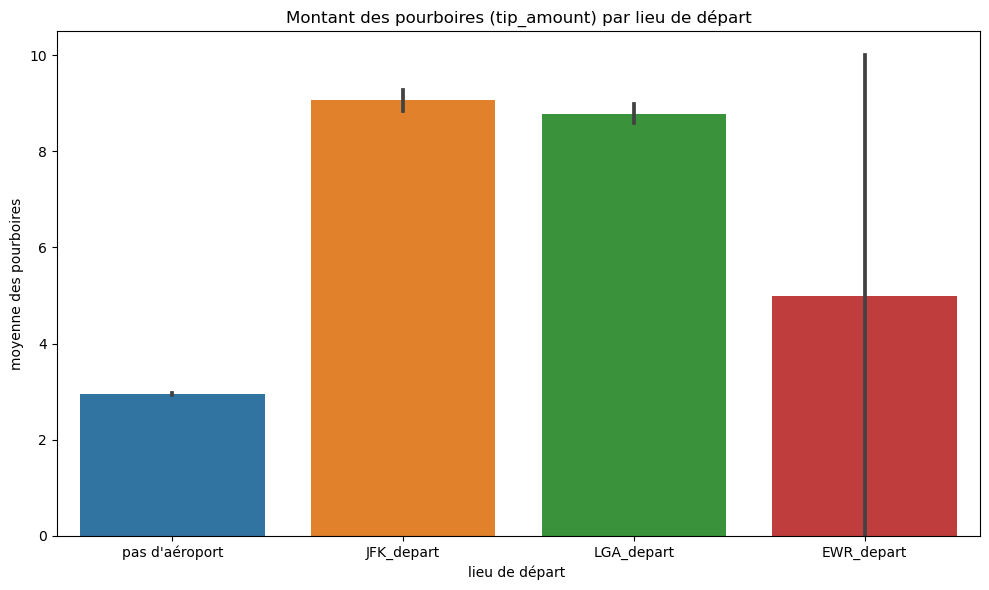

In [297]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_train, x='aeroport_class_depart', y='tip_amount', estimator= 'mean' )

plt.title('Montant des pourboires (tip_amount) par lieu de départ')
plt.xlabel('lieu de départ ')
plt.ylabel('moyenne des pourboires')
plt.tight_layout()
plt.show()

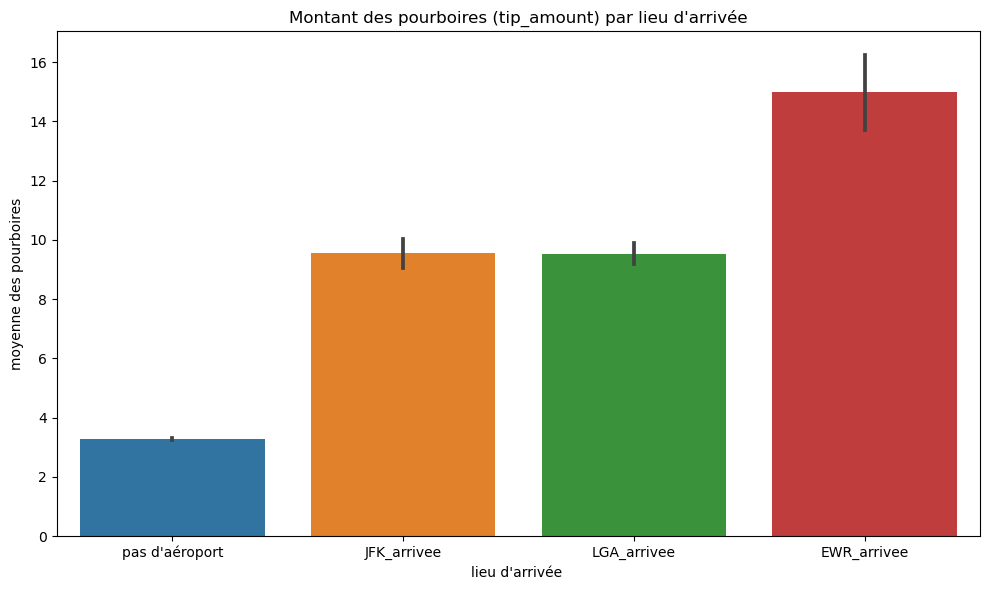

In [298]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_train, x='aeroport_class_arrivee', y='tip_amount', estimator='mean')

plt.title("Montant des pourboires (tip_amount) par lieu d'arrivée")
plt.xlabel("lieu d'arrivée ")
plt.ylabel('moyenne des pourboires')
plt.tight_layout()
plt.show()

Nous pouvons observer un différence nettement significative entre certain aéroport et s'il n'y à pas d'aéroport, dans les trajets d'arrivée comme de départ.

Nous pouvons donc assumer que cette variable va donc être importante. Cependant son information est déjà contenue dans ces quatre variables : PU_location_lat, PU_location_lon, DO_location_lat et DO_location_lon.

Nous n'allons donc pas garder la variable créer, mais dans nos futurs choix de variables, nous garderons les localisations.

In [299]:
df_train = df_train.drop(columns='aeroport_class_depart')
df_train = df_train.drop(columns='aeroport_class_arrivee')

## B. One-hot-encoding pour les variables qualitatives

In [300]:
quali = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'payment_type','improvement_surcharge','Airport_fee', 'periode']

for i, colonne in enumerate(quali):
    df_train[colonne] = df_train[colonne].astype('category')
    df_test[colonne] = df_test[colonne].astype('category')

# One-hot-encoding
X_train = pd.get_dummies(df_train, columns=quali, drop_first=True)
X_test = pd.get_dummies(df_test, columns=quali, drop_first=True)

## C. Choix de variables

In [301]:
Y = X_train['tip_amount']
X_train = X_train.drop(columns='tip_amount')

### Jeux de données

In [302]:
df_train_periode_duree = X_train.drop(columns=['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres'])
df_test_periode_duree = X_test.drop(columns=['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres'])

df_train_periode_duree_meteo = X_train
df_test_periode_duree_meteo = X_test

### Normalisation et standardisation

In [303]:
# Avec toutes les variables, sans les variables de météo

# Séparer les colonnes quantitatives et qualitatives
df_train_periode_duree_quali  = df_train_periode_duree.select_dtypes(include='bool')
df_test_periode_duree_quali  = df_test_periode_duree.select_dtypes(include='bool')

df_train_periode_duree_quanti = df_train_periode_duree.select_dtypes(include='float')
df_test_periode_duree_quanti = df_test_periode_duree.select_dtypes(include='float')

# Normalisation des données quantitatives
scaler = StandardScaler()
X_train_periode_duree_quanti_scaled = scaler.fit_transform(df_train_periode_duree_quanti)
X_test_periode_duree_quanti_scaled = scaler.transform(df_test_periode_duree_quanti)

In [304]:
# Avec toutes les variables

# Séparer les colonnes quantitatives et qualitatives
df_train_periode_duree_meteo_quali = df_train_periode_duree_meteo.select_dtypes(include='bool')
df_test_periode_duree_meteo_quali = df_test_periode_duree_meteo.select_dtypes(include='bool')

df_train_periode_duree_meteo_quanti = df_train_periode_duree_meteo.select_dtypes(include='float')
df_test_periode_duree_meteo_quanti = df_test_periode_duree_meteo.select_dtypes(include='float')

# Normalisation des données quantitatives
scaler = StandardScaler()
X_train_periode_duree_meteo_quanti_scaled = scaler.fit_transform(df_train_periode_duree_meteo_quanti)
X_test_periode_duree_meteo_quanti_scaled = scaler.transform(df_test_periode_duree_meteo_quanti)

### ACP

#### Données sans la météo

In [305]:
# On fait l'ACP sur les données quantitatives normalisées
X_train_periode_duree_quanti_scaled 
X_test_periode_duree_quanti_scaled

pca = PCA() 
X_train_quanti_pca = pca.fit_transform(X_train_periode_duree_quanti_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

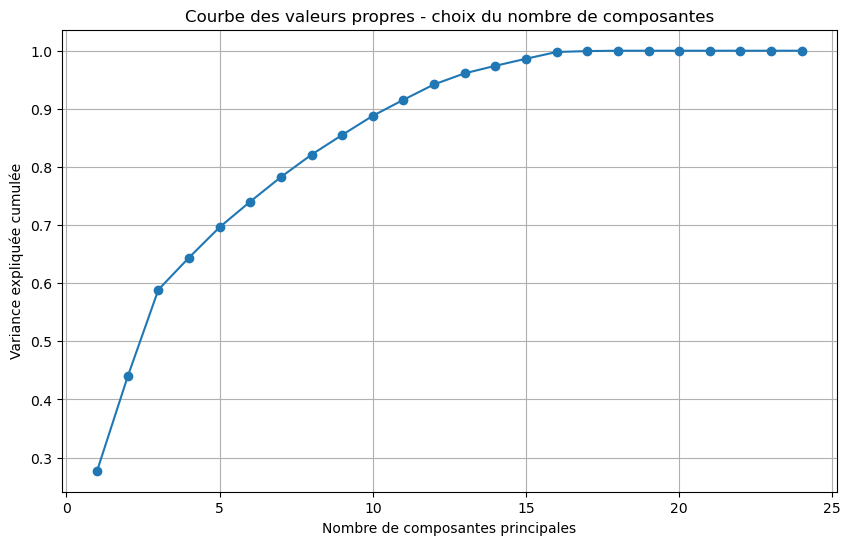

In [306]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée cumulée')
plt.title('Courbe des valeurs propres - choix du nombre de composantes')
plt.grid(True)
plt.show()

In [307]:
# Réajustement de l'ACP pour ne conserver que les 8 premières composantes
pca = PCA(n_components=8)

X_train_periode_duree_quanti_pca = pca.fit_transform(X_train_periode_duree_quanti_scaled)
X_test_periode_duree_quanti_pca = pca.transform(X_test_periode_duree_quanti_scaled) # Réduction avec la même ACP 

#### Données avec la météo

In [308]:
# Instanciation et ajustement de l'ACP sur les données d'entraînement
pca = PCA()
X_train_jour_periode_duree_meteo_quanti_pca = pca.fit_transform(X_train_periode_duree_meteo_quanti_scaled)

# Calcul de la variance expliquée par chaque composante principale
explained_variance_meteo = pca.explained_variance_ratio_
cumulative_variance_meteo = np.cumsum(explained_variance_meteo)

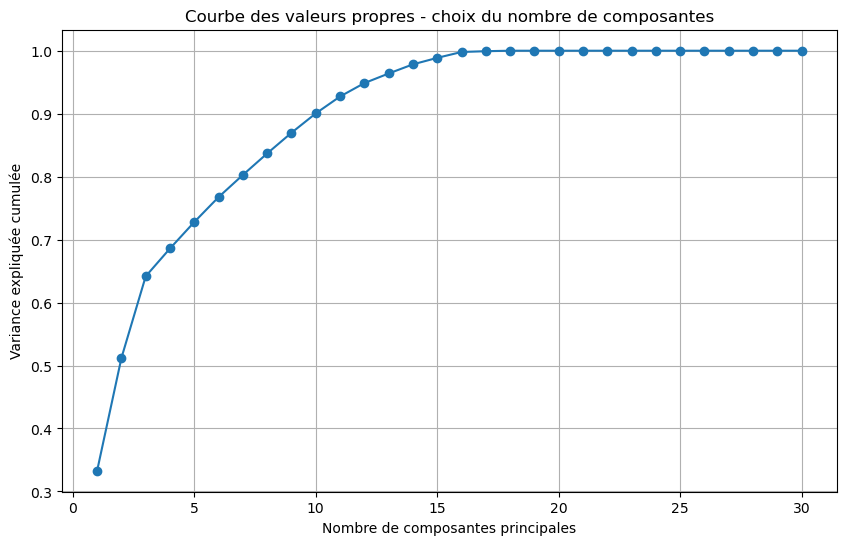

In [309]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_meteo) + 1), cumulative_variance_meteo, marker='o', linestyle='-')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée cumulée')
plt.title('Courbe des valeurs propres - choix du nombre de composantes')
plt.grid(True)
plt.show()

In [310]:
# Réajustement de l'ACP pour ne conserver que les 11 premières composantes
pca = PCA(n_components=11)
X_train_periode_duree_meteo_quanti_pca = pca.fit_transform(X_train_periode_duree_meteo_quanti_scaled)
X_test_periode_duree_meteo_quanti_pca = pca.transform(X_test_periode_duree_meteo_quanti_scaled)

### Jeu de données pour la construction des modèles

In [311]:
# Convertir les résultats de l'ACP en DataFrame avec des noms de colonnes clairs
X_train_periode_duree_quanti_pca_df = pd.DataFrame(X_train_periode_duree_quanti_pca, index = df_train_periode_duree.index, columns=[f'pca_{i+1}' for i in range(X_train_periode_duree_quanti_pca.shape[1])])
X_test_periode_duree_quanti_pca_df = pd.DataFrame(X_test_periode_duree_quanti_pca, index = df_test_periode_duree.index, columns=[f'pca_{i+1}' for i in range(X_test_periode_duree_quanti_pca.shape[1])])

X_train_periode_duree_meteo_quanti_pca_df = pd.DataFrame(X_train_periode_duree_meteo_quanti_pca, index = df_train_periode_duree_meteo.index, columns=[f'pca_{i+1}' for i in range(X_train_periode_duree_meteo_quanti_pca.shape[1])])
X_test_periode_duree_meteo_quanti_pca_df = pd.DataFrame(X_test_periode_duree_meteo_quanti_pca, index = df_test_periode_duree_meteo.index, columns=[f'pca_{i+1}' for i in range(X_test_periode_duree_meteo_quanti_pca.shape[1])])

# Concaténer les composantes principales avec les variables qualitatives pour chaque jeu de données
df_train_periode_duree_pca = pd.concat([X_train_periode_duree_quanti_pca_df, df_train_periode_duree_quali.reset_index(drop=True)], axis=1)
df_test_periode_duree_pca = pd.concat([X_test_periode_duree_quanti_pca_df, df_test_periode_duree_quali.reset_index(drop=True)], axis=1)

df_train_periode_duree_meteo_pca = pd.concat([X_train_periode_duree_meteo_quanti_pca_df, df_train_periode_duree_meteo_quali.reset_index(drop=True)], axis=1)
df_test_periode_duree_meteo_pca = pd.concat([X_test_periode_duree_meteo_quanti_pca_df, df_test_periode_duree_meteo_quali.reset_index(drop=True)], axis=1)

##### Nos différents jeux de données

>- df_train_periode_duree 
>- df_test_periode_duree

>- df_train_periode_duree_pca 
>- df_test_periode_duree_pca

>- df_train_periode_duree_meteo 
>- df_test_periode_duree_meteo

>- df_train_periode_duree_meteo_pca 
>- df_test_periode_duree_meteo_pca

>- Y

# III. Modèles

Nous allons tester 3 modèles différents :

> Un modèle pour capturer les relations linéaires
> - Régression linéaire

> Deux modèles pour capturer les relations non linéaires entre les variables
> - Random Forest
> - Grandient Boosting

In [334]:
def prediction_test(dataset_X, Y, dataset_test, path_out, model_constructor, **kwags):
    """
    Entraîne un modèle sur des données d'entraînement, prédit les valeurs sur un jeu de test, 
    applique des corrections aux prédictions, et exporte les résultats sous forme de fichier CSV.

    Parameters:
    ----------
    dataset_X : pandas.DataFrame
        Les données d'entraînement contenant les caractéristiques (*features*).
    Y : pandas.Series ou numpy.ndarray
        Les cibles (*labels*) correspondant aux données d'entraînement.
    dataset_test : pandas.DataFrame
        Les données sur lesquelles effectuer les prédictions.
    model : callable
        Un constructeur de modèle compatible avec scikit-learn.
    *kwags : tuple
        Les arguments supplémentaires pour le constructeur du modèle.
    path_out : str
        Le chemin du fichier CSV où sauvegarder les prédictions.

    Returns:
    -------
    None
        Les prédictions sont sauvegardées dans un fichier CSV à l'emplacement spécifié par `path_out`.

    """
    model = model_constructor(**kwags)
    model.fit(dataset_X, Y)
    y_pred = model.predict(dataset_test)
    
    y_test_pred_df = pd.DataFrame(y_pred, columns=['tip_amount_pred'], index=data_test.index)

    # Mettre à zéro pour les indices identifiés comme trajets annulés
    indices_trajets_annules = data_test[data_test['tpep_pickup_datetime'] == data_test['tpep_dropoff_datetime']].index
    y_test_pred_df.loc[indices_trajets_annules, 'tip_amount_pred']
    y_pred = np.array(y_test_pred_df['tip_amount_pred'])
    
    # Remplacer les valeurs négatives par zéro
    y_pred = np.where(y_pred < 0, 0, y_pred)
    
    predictions_df = pd.DataFrame({'tip_amount': y_pred})
    predictions_df['row_ID'] = predictions_df.index
    predictions_df = predictions_df[['row_ID', 'tip_amount']]

    predictions_df.to_csv(path_out, index=False, header=True)

## A. Régression Linéaire

### Score du R² en Cross Validation

In [313]:
model = LinearRegression()

# Évaluer le modèle par validation croisée avec R² comme métrique
scores = cross_val_score(model, df_train_periode_duree , Y, scoring=make_scorer(r2_score), cv=5) # dataset a personnaliser

print("Scores de validation croisée R² pour chaque pli :", scores)
print("Score moyen R² :", scores.mean())

Scores de validation croisée R² pour chaque pli : [0.63628065 0.55946608 0.60375765 0.63258016 0.62605142]
Score moyen R² : 0.6116271909879597


### Score du R² public

In [323]:
# Exemple à personnaliser
dataset_X = df_train_periode_duree
Y
dataset_test = df_test_periode_duree
model_constructor = LinearRegression
# path_out = a personnaliser

prediction_test(dataset_X, Y, dataset_test, path_out, model_constructor)

#### Résultats

##### Modèle RL1
> - Jeu de données : df_train_periode_duree
> - Score CV R² : 0.6116386667554826
> - Score public R² : 0.6163

##### Modèle RL2
> - Jeu de données : df_train_periode_duree_meteo
> - Score CV R² : 0.6116271909879597
> - Score public R² : 0.6163

##### Modèle RL3
> - Jeu de données : df_train_periode_duree_pca
> - Score CV R² : 0.5901943450649221
> - Score public R² : 0.5940

##### Modèle RL4
> - Jeu de données : df_train_periode_duree_meteo_pca
> - Score CV R² : 0.5914161062028855
> - Score public R² : 0.5950

## B. Random Forest

### Recherche d'hyperparamètres

In [ ]:
rf_model = RandomForestRegressor(random_state=123)

# Grille d'hyperparamètres
param_grid = {'n_estimators': [100, 200, 500],
              'max_depth': [10, 20, 30, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['sqrt']}

r2_scorer = make_scorer(r2_score)

cv = KFold(n_splits=10, shuffle=False)

# Configurer la recherche d'hyperparamètres avec RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model,
                                   param_distributions=param_grid,
                                   n_iter=20,  # Nombre de combinaisons aléatoires à tester
                                   scoring=r2_scorer,
                                   cv=cv,
                                   random_state=123,  # Reproductibilité
                                   n_jobs=-1)

random_search.fit(df_train_periode_duree_meteo, Y)

best_params = random_search.best_params_
print("Meilleurs paramètres trouvés:", best_params)

best_score = random_search.best_score_
print("Meilleur score R² (validation croisée):", best_score)

Meilleurs paramètres trouvés: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}

### Score du R² en Cross Validation

In [328]:
rf_model = RandomForestRegressor(n_estimators=500, min_samples_split=10, min_samples_leaf=1, max_features='sqrt', 
                                 max_depth=20, bootstrap=True, random_state=123)

scores = cross_val_score(rf_model, df_train_periode_duree , Y, scoring=make_scorer(r2_score), cv=5)

print("Scores de validation croisée R² pour chaque pli :", scores)
print("Score moyen R² :", scores.mean())

Scores de validation croisée R² pour chaque pli : [0.72468374 0.63752279 0.6882968  0.72075981 0.71405259]
Score moyen R² : 0.6970631466816875


### Score du R² public

In [335]:
# Exemple à personnaliser
dataset_X = df_train_periode_duree
Y
dataset_test = df_test_periode_duree
model_constructor = RandomForestRegressor
path_out = r"C:\Users\alici\Documents\Cours\Universite\MIA\M2\SP\Challenges\Taxis_tips\nyc-taxis-tips\prediction_a_jeter.csv"

prediction_test(dataset_X, Y, dataset_test, path_out, model_constructor, n_estimators=500, min_samples_split=10, 
                min_samples_leaf=1, max_features='sqrt', max_depth=20, bootstrap=True, random_state=123)

#### Résultats

Grid Search sur df_train_periode_duree_meteo

Parameters : {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}

##### Modèle RF1
> - Jeu de données : df_train_periode_duree
> - Score OOB R² : 0.6989548880444594
> - Score public R² :0.69388

##### Modèle RF2
> - Jeu de données : df_train_periode_duree_meteo
> - Score OOB R² : 0.69690252475094
> - Score public R² : 0.69073

##### Modèle RF3
> - Jeu de données : df_train_periode_duree_pca
> - Score OOB R² : 0.6926306941860689
> - Score public R² : 0.68865

##### Modèle RF4
> - Jeu de données : df_train_periode_duree_meteo_pca
> - Score OOB R² : 0.6927502752898105
> - Score public R² : 0.68735

## C. Gradient Boosting

### Recherche d'hyperparamètres 

In [ ]:
gb_model = GradientBoostingRegressor(random_state=123)

# Grille d'hyperparamètres à tester
param_distributions = {'n_estimators': [200, 500, 1000],
                       'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
                       'max_depth': [3, 5, 6, 7, 10,],
                       'min_samples_split': [2, 5, 10],
                       'min_samples_leaf': [1, 4, 5, 6],
                       'subsample': [0.7],
                       'max_features': ['sqrt']}

r2_scorer = make_scorer(r2_score)

# Configurer la recherche d'hyperparamètres avec RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=gb_model,
                                   param_distributions=param_distributions,
                                   scoring=r2_scorer,
                                   cv=5,
                                   n_iter=100,
                                   n_jobs=-1,
                                   random_state=123)

random_search.fit(df_train_periode_duree_meteo, Y)

best_params = random_search.best_params_
print("Meilleurs paramètres trouvés :", best_params)

Meilleurs paramètres trouvés : {'subsample': 0.7, 'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.01}

### Score du R² en Cross Validation

In [332]:
gb_model = GradientBoostingRegressor(subsample=0.7, n_estimators=1000, min_samples_split=5, min_samples_leaf=6, 
                                     max_features='sqrt', max_depth=5, learning_rate=0.01, random_state=123)

scores = cross_val_score(gb_model, df_train_periode_duree, Y, scoring=make_scorer(r2_score), cv=5)

print("Scores de validation croisée R² pour chaque pli :", scores)
print("Score moyen R² :", scores.mean())

Scores de validation croisée R² pour chaque pli : [0.73546754 0.64260137 0.69817484 0.72945756 0.72358938]
Score moyen R² : 0.7058581370584499


### Score du R² public

In [ ]:
# Exemple à personnaliser
dataset_X = df_train_periode_duree
Y
dataset_test = df_test_periode_duree
model_constructor = GradientBoostingRegressor
# path_out = à personnaliser

prediction_test(dataset_X, Y, dataset_test, path_out, model_constructor, subsample=0.7, n_estimators=1000, min_samples_split=5, 
                min_samples_leaf=6, max_features='sqrt', max_depth=5, bootstrap=True, random_state=123)

#### Résultats

Grid Search sur df_train_periode_duree_meteo

Parameters : {'subsample': 0.7, 'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.01}

##### Modèle GB1
> - Jeu de données : df_train_periode_duree
> - Score CV R² : 0.7058849922188883
> - Score public R² : 0.69556

##### Modèle GB2
> - Jeu de données : df_train_periode_duree_meteo
> - Score CV R² : 0.7059981421105316
> - Score public R² : 0.69455

##### Modèle GB3
> - Jeu de données : df_train_periode_duree_pca
> - Score CV R² : 0.6940757358693056
> - Score public R² : 0.68398

##### Modèle GB4
> - Jeu de données : df_train_periode_duree_meteo_pca
> - Score CV R² : 0.6938809832010768
> - Score public R² : 0.68342